# Sentinel-2 example notebook

This notebook showcases how to use  `PASEOS` to implement **Sentinel2-A (S2A)** and **Sentinel2-B (S2B)**. In particular, the notebook shows how to create `space_actors` orbiting as the **S2A** and **S2B** around Earth. In addition, it shows how to add `power` and `communication` devices. Furthermore, it demonstrates how to register activities to perform onboard data acquisition and processing to detect **volcanic eruptions** on `Sentinel-2 L1C data`. <br> **DISCLAIMER**: the notebook requires `rasterio` to run correctly, which is not included in the packets required to install `PASEOS`. To install `rasterio` you can use: <br><center>  ```conda install -c conda-forge rasterio``` or alternatively ```pip install rasterio``` </center>

Let's start with importing the requested packages.

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
import os
sys.path.insert(1, os.path.join("..",".."))
import pykep as pk
import numpy as np
import paseos
from paseos import ActorBuilder, SpacecraftActor
from utils import s2pix_detector, acquire_data
from paseos.utils.load_default_cfg import load_default_cfg
from paseos.visualization.space_animation import SpaceAnimation
import asyncio
import urllib.request
import matplotlib.pyplot as plt

18:30:58|PASEOS-DEBUG| Setting LogLevel to DEBUG
18:30:58|PASEOS-DEBUG| Loaded module.


Setting logging level of `paseos` to `INFO` to reduce the verbosity of the execution.

In [2]:
paseos.set_log_level("INFO")

# 1) - Instantiate Sentinel 2 space actors

First of all, let's create the scaffolds for **S2A** and **S2B**. The scaffolds are objects which are not equipped with any `communication_device` nor `power_devices`. Furthermore, they neither have any `orbit`. 

In [3]:
S2A = ActorBuilder.get_actor_scaffold(
    "Sentinel2-A", SpacecraftActor, [0,0,0], pk.epoch(0)
)

# Define local actor
S2B = ActorBuilder.get_actor_scaffold(
    "Sentinel2-B", SpacecraftActor, [0,0,0], pk.epoch(0)
)

#### 1.a) - Add an orbit for S2A and S2B

Since **S2A** and **S2B** are orbiting around Earth, let's define `earth` as `pykep.planet` object. 

In [4]:
# Define central body
earth = pk.planet.jpl_lp("earth")

To find a realistic orbits for **S2A** and **S2B**, we can exploit `Two Line Elements (TLEs)` (Downloaded on 27-10-2022). This would allow finding their ephemerides at time = 27-10-2022 12:00:00.

In [5]:
#Define today as pykep epoch (27-10-22)
today = pk.epoch_from_string('2022-10-27 12:00:00.000')

sentinel2A_line1 = "1 40697U 15028A   22300.01175178 -.00001065  00000+0 -38995-3 0  9999"
sentinel2A_line2 = "2 40697  98.5650  12.8880 0001080  78.8662 281.2690 14.30806819383668"
sentinel2A = pk.planet.tle(sentinel2A_line1, sentinel2A_line2)

#Calculating S2A ephemerides.
sentinel2A_eph=sentinel2A.eph(today)

sentinel2B_line1 = "1 42063U 17013A   22300.18652110  .00000099  00000+0  54271-4 0  9998"
sentinel2B_line2 = "2 42063  98.5693  13.0364 0001083 104.3232 255.8080 14.30819357294601"
sentinel2B = pk.planet.tle(sentinel2B_line1, sentinel2B_line2)

#Calculating S2B ephemerides.
sentinel2B_eph=sentinel2B.eph(today)


**S2A** and **S2B** are always in phase opposition. The next cell show the positions of the two satellites in different instants (`2022-Oct-27 12:00:00`, `blue`) and (`2022-Oct-27 12:19:59`, `red`). 

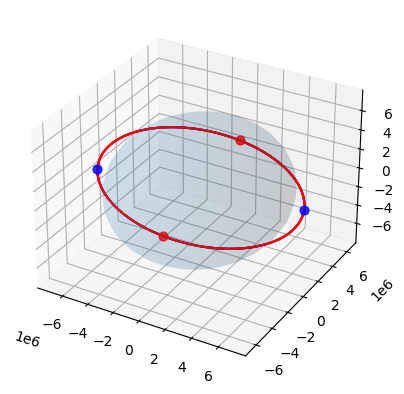

In [6]:
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:30j]
x = pk.EARTH_RADIUS * np.cos(u) * np.sin(v)
y = pk.EARTH_RADIUS * np.sin(u) * np.sin(v)
z = pk.EARTH_RADIUS * np.cos(v)
ax=pk.orbit_plots.plot_planet(sentinel2A,t0=today, color="b")
ax=pk.orbit_plots.plot_planet(sentinel2B,t0=today, axes=ax, color="b")
ax=pk.orbit_plots.plot_planet(sentinel2A,t0=pk.epoch(today.mjd2000 + 60 * 20 * pk.SEC2DAY), axes=ax, color="r")
ax=pk.orbit_plots.plot_planet(sentinel2B,t0=pk.epoch(today.mjd2000 + 60 * 20 * pk.SEC2DAY), axes=ax, color="r")
ax.plot_surface(x,y,z,alpha=0.1)

Since **S2A** and **S2B** are always in phase opposition, any communication between the satellites is impossible. Therefore, we will now set the **S2B** space actor orbit by inverting the direction of its speed. In a real case scenario, the satellites might end up colliding in this set-up... but let's forget about it :)

In [7]:
#Adding orbits around Earth based on previously calculated ephemerides
ActorBuilder.set_orbit(S2A, sentinel2A_eph[0], sentinel2A_eph[1], today, earth)

# To enable the communication between S2A and S2B, the velocity vector is multiplied by - 1 making the satellite to orbit with opposite direction.
ActorBuilder.set_orbit(S2B, sentinel2B_eph[0], [-sentinel2B_eph[1][0], -sentinel2B_eph[1][1],-sentinel2B_eph[1][2]], today, earth)

### 1.b) - Add communication and power devices

Adding power devices. Max battery level: 102 Ah @ 28V is 2.81 kWh (effect of aging is neglected).  To identify the charging rate, we are assuming to be dependent only by the power of solar panels. We are neglecting eventual charging rate limits due to battery technology. The solar-panels power is 2300 W at begin of life and 1730 W at end of life. <br> Please, refer to: [Copernicus: Sentinel-2](https://www.eoportal.org/satellite-missions/copernicus-sentinel-2#space-segment.)

In [8]:
ActorBuilder.set_power_devices(S2A, battery_level_in_Ws=10080000, max_battery_level_in_Ws=10080000, charging_rate_in_W=1736)
ActorBuilder.set_power_devices(S2B, battery_level_in_Ws=10080000, max_battery_level_in_Ws=10080000, charging_rate_in_W=1860)


Adding communication devices. Here we assume Sentinel 2A and Sentinel 2B to have an Inter-Satellite-Link at 100 Mbps.

In [9]:
ActorBuilder.add_comm_device(S2A, "isl_transmitter", 100000)
ActorBuilder.add_comm_device(S2B, "isl_transmitter", 100000)

# 2) - Instantiate PASEOS simulation

To instantiate `PASEOS`, we consider **S2A** as `local_actor`. The initial time is set to `today`.

In [10]:
# init simulation
cfg=load_default_cfg()
cfg.sim.start_time=today.mjd2000 * pk.DAY2SEC
sim = paseos.init_sim(S2A, cfg)

We now add **S2B** to the simulation.

In [11]:
sim.add_known_actor(S2B)

## 3) - Dealing with PASEOS activities 

Here we demonstrate how you can use register and perform activities with `PASEOS`. To this aim, we will use `fetection of volcanic eruptions` as use case, assuming it will be possible to run it onboard `S2A`. To this aim, we will use a simplified version of the algorithm `[1] Massimetti, Francesco, et al. ""Volcanic hot-spot detection using SENTINEL-2: a comparison with MODIS–MIROVA thermal data series."" Remote Sensing 12.5 (2020): 820.` The algorithm leverages on bands `B8A`, `B11` and `B12` and perform pixel-level detection. <br> We will assume S2A will acquire images and then process them by using [1]. In this notebook, we assume to be able to detect the following images regardless their proper geografical position. We thanks the `ESA` project `Sentinel2_L0` for providing images and the implementation of [1]. 

The next cell will download the files that are needed to execute the next parts of the notebook. The files belongs to the `Sentinel2_L0` dataset project (to be released soon with GPL license).

In [12]:
urllib.request.urlretrieve("https://actcloud.estec.esa.int/actcloud/index.php/s/9Tw5pEbGbVO3Ttt/download", "Etna_00.tif")
urllib.request.urlretrieve("https://actcloud.estec.esa.int/actcloud/index.php/s/vtObKJOuYLgdPf4/download", "La_Palma_02.tif")
urllib.request.urlretrieve("https://actcloud.estec.esa.int/actcloud/index.php/s/e0MyilW1plYdehL/download", "Mayon_02.tif")


('Mayon_02.tif', <http.client.HTTPMessage at 0x1ed785e9870>)

### 3.a) - Registering activities 

The next lines will show how to register an activity to simulate data acquisition on **S2A**. <Br>Each activity is bounded to an `asynchronous functions`.  Let's define the asynchornous function `acquire_data_async()´ as follow.

In [13]:
async def acquire_data_async(args):
    args[1][0]=acquire_data(args[0])
    await asyncio.sleep(3.4) #Acquisition for an L0 granule takes 3.6 seconds for S2A. 

The function `acquire_data_async()` uses `args[0]` as a filename to load the file and saves the acquired image into `args[1][0]`. Please, notice that using `args[1][0]` instead of `args[1]` is just a trick to be sure the acquired data are modifies the input argument `args[1]` by reference without creating a local copy of it. 
Therefore, let's define a placeholder `data_acquired` as a list containing 3 lists with `None` elements, which will be overwritted by `acquire_data_async()`.

In [14]:
data_acquired=[[None], [None], [None]]

The next line will register the activity `data_acquisition` by associating int to the `activity_function` previously defined, `acquire_data_async`. It is up to the user to specify the power consumption in W for the activity. For Sentinel-2, the peak power of the imager is 266 W as reported in [Copernicus: Sentinel-2](https://www.eoportal.org/satellite-missions/copernicus-sentinel-2#space-segment.)

In [15]:
# Register an activity that emulate data acquisition
sim.register_activity(
    "data_acquisition", activity_function=acquire_data_async, power_consumption_in_watt=266
)


Simlarly, we can register an activity to perform the volcanic event detection. 

In [16]:
#Output event mask
output_event_masks=[[None], [None], [None]]

async def detect_volcanic_eruptions_async(args):
    args[1][0]=s2pix_detector(args[0][0])
    await asyncio.sleep(0.1)

# Register an activity that emulate event detection
sim.register_activity(
    "volcanic_event_detection", activity_function=detect_volcanic_eruptions_async, power_consumption_in_watt=10
)


### 3.b) - Performing activities.

We can now perform the activities. In scheduling the activities, we assume that data are acquired and stored into the mass memory to be, then, processed during the off part of the satellite duty cycle. Please, refer to: [Copernicus: Sentinel-2](https://www.eoportal.org/satellite-missions/copernicus-sentinel-2#space-segment.) Please note that, when `sim.perform_activity(...)` is called, the keyword `await` is needed  **only for Jupyter notebooks** to ensure the correct management of asynchronous functions. **Remove it otherwise**.

In [17]:
data_to_acquire=["Etna_00.tif", "La_Palma_02.tif", "Mayon_02.tif"]

#Data acquisition
for n, data_name in zip(range(len(data_to_acquire)), data_to_acquire):
    #Run the activity
    await sim.perform_activity("data_acquisition", activity_func_args=[data_name, data_acquired[n]])


#Data processing
for n in range(len(data_to_acquire)):
    #Run the activity
    await sim.perform_activity("volcanic_event_detection", activity_func_args=[data_acquired[n],output_event_masks[n]])


### 3.c) - Results visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


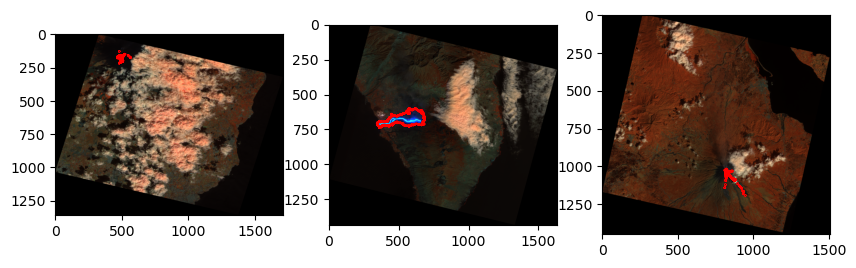

In [18]:
fig, ax=plt.subplots(1,3,figsize=(10,10))

for n in range(3):
    ax[n].imshow(data_acquired[n][0])
    ax[n].contour(output_event_masks[n][0], colors="r")

## 4) - PASEOS visualization

The next cell allows the `PASEOS` animations, based on `matplotlib`, to work correctly in the notebook.

In [19]:
%matplotlib notebook

The next cell allows instantiate a plotter that can be used to visualizer `PASEOS` animations. Once opened, the `plotter` will display the position of `S2A`and `S2B` around the orbit. It also shows the state of charge of the batteries, possibility to communicate, and other parameters for all the actors. <br> **N.B.** Only the battery status of the **local actor** (displayed in <span style="color:green">green</span>) will be updated over the time, since this instance of `PASEOS` is not aware of the activities performed by the other actors.

<IPython.core.display.Javascript object>


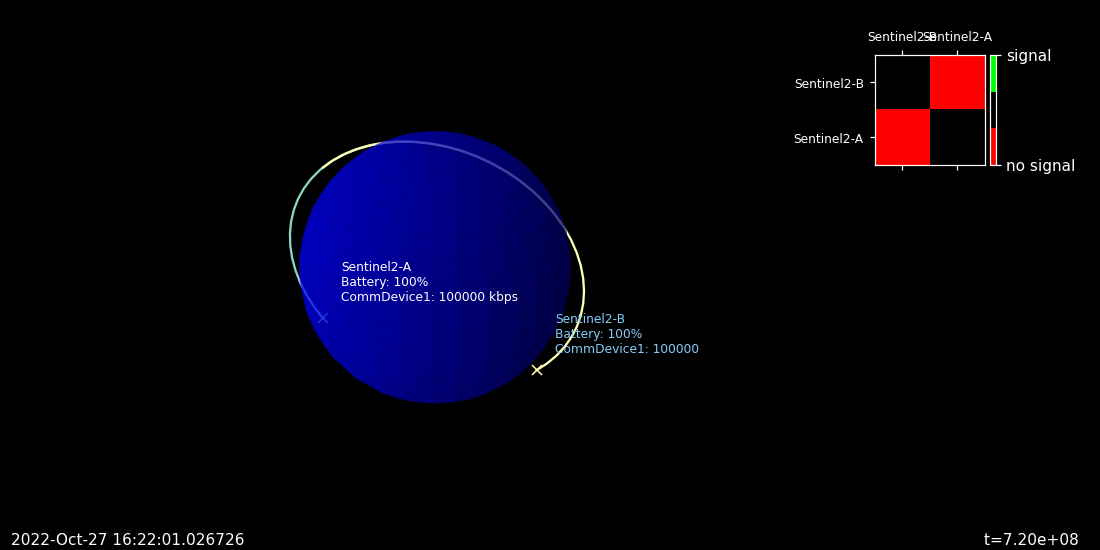

In [20]:
# Plot current status of PASEOS and get a plotter
plotter = paseos.plot(sim, paseos.PlotType.SpacePlot)

Now, we can advance the simulation and observe how the satellite status and position change over time. 

In [ ]:
dt=100 # Incremental step [s]
N_steps = 100 # Number of steps

for n in range(N_steps):
    sim.advance_time(dt)  # This command will advance the simulation time of a dt
    plotter.update(sim)  # This command will update the plot accordingly.